## QUANTUM AUTOENCODER ##

In [1]:
import time
import pennylane as qml
import matplotlib.pyplot as plt
import numpy as np
import csv
from pennylane import numpy

/Users/edoardozappia/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
def ansatz(init_weights, weights):
    qml.SimplifiedTwoDesign(initial_layer_weights=init_weights, weights=weights, wires=range(n_wires_latent+n_wires_trash))

In [3]:
def swap_test(num_latent, num_trash):
    auxiliary_qubit = num_latent + 2 * num_trash
    qml.Hadamard(auxiliary_qubit)
    for i in range(num_trash):
        qml.CSWAP(wires=[auxiliary_qubit, num_latent + i, num_latent + num_trash + i])
    qml.Hadamard(auxiliary_qubit)

In [4]:
n_wires_latent = 3
n_wires_trash = 2
n_wires_total = n_wires_latent + 2 * n_wires_trash +1

In [5]:
dev = qml.device("default.qubit", wires=n_wires_total)

In [6]:
def quantum_encoder_train(init_weights, weights, n_wires_latent, n_wires_trash):
    ansatz(init_weights, weights)
    swap_test(n_wires_latent, n_wires_trash)

In [7]:
@qml.qnode(dev)
def domain_wall(init_weights, weights):
    qml.X(2)
    qml.X(3)
    qml.X(4)
    quantum_encoder_train(init_weights, weights, n_wires_latent, n_wires_trash)
    return qml.expval(qml.Z(7))

In [13]:
initial_point = np.random.random(n_wires_latent)

In [49]:
shapes = qml.SimplifiedTwoDesign.shape(n_layers=2, n_wires=n_wires_latent+n_wires_trash)
weights = [np.random.random(size=shape) for shape in shapes]
print(np.shape(weights[0]))
print(shapes)
initial_point = weights[0]
weights = weights[1]
print(np.shape(weights))
print(initial_point)
#print(weights)

(5,)
[(5,), (2, 4, 2)]
(2, 4, 2)
[0.09813147 0.11931003 0.43776312 0.78242309 0.33314272]


In [12]:
initial_point = np.random.random((5,))
#initial_point = np.reshape(initial_point, (5,))
print(np.shape(initial_point))
initial_point = qml.numpy.tensor(initial_point, requires_grad=True)
weights = np.random.random((2, 4, 2))
weights = qml.numpy.tensor(weights, requires_grad=True)
print(np.shape(weights))
print(weights)

(5,)
(2, 4, 2)
[[[0.22090102 0.48126861]
  [0.59086773 0.13742641]
  [0.7339206  0.99864077]
  [0.78205824 0.64474591]]

 [[0.28831933 0.21285388]
  [0.95560043 0.72402451]
  [0.68293128 0.21724965]
  [0.90513907 0.79443295]]]


(<Figure size 800x900 with 1 Axes>, <Axes: >)


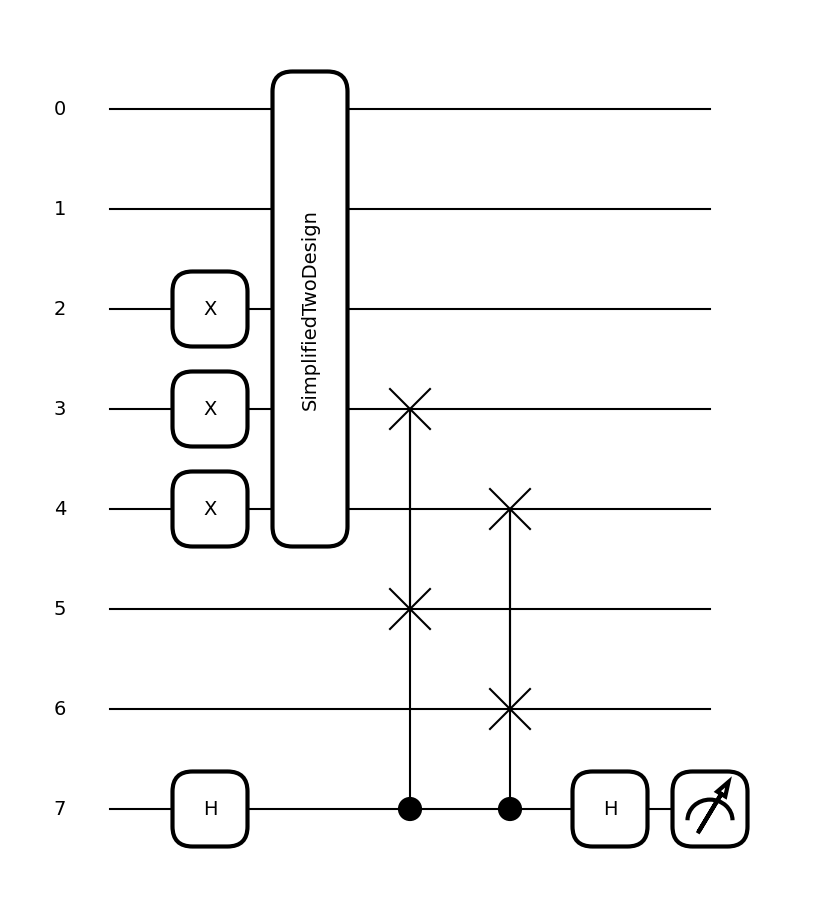

In [13]:
drawer = qml.draw_mpl(domain_wall)
print(drawer(initial_point, weights))

In [14]:
def cost_function(init_weights, weights):
    # Calcola il valore atteso di Z sulla settima qubit
    expectation_value = domain_wall(init_weights, weights)
    print(f"Expectation value: {expectation_value}")
    # La funzione di costo è la somma delle probabilità di ottenere 1
    prob_1 = 0.5 * (1 - expectation_value)
    print(f"Probability of measuring 1: {prob_1}")
    return prob_1

In [15]:
initial_cost = cost_function(initial_point, weights)
print(f"Costo iniziale: {initial_cost:.4f}")

Expectation value: 0.07554519894586753
Probability of measuring 1: 0.46222740052706623
Costo iniziale: 0.4622


In [16]:
# Inizializzazione dell'ottimizzatore
opt = qml.GradientDescentOptimizer(stepsize=0.1)
steps = 150
costs = []

# Ciclo di addestramento
start = time.time()
for i in range(steps):
    weights, cost_val = opt.step_and_cost(lambda w: cost_function(initial_point, w), weights)
    costs.append(cost_val)
    if i%5==0:
        print(f"Step {i+1}: cost = {cost_val:.4f}")

elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} seconds")
# Stampa dei pesi ottimizzati
print("Pesi ottimizzati:", weights)

Expectation value: Autograd ArrayBox with value 0.07554519894586753
Probability of measuring 1: Autograd ArrayBox with value 0.46222740052706623
Step 1: cost = 0.4622
Expectation value: Autograd ArrayBox with value 0.07835645443351152
Probability of measuring 1: Autograd ArrayBox with value 0.4608217727832442
Expectation value: Autograd ArrayBox with value 0.08130753375014782
Probability of measuring 1: Autograd ArrayBox with value 0.45934623312492606
Expectation value: Autograd ArrayBox with value 0.08440654497338973
Probability of measuring 1: Autograd ArrayBox with value 0.45779672751330514
Expectation value: Autograd ArrayBox with value 0.08766208175750917
Probability of measuring 1: Autograd ArrayBox with value 0.45616895912124544
Expectation value: Autograd ArrayBox with value 0.0910832472964665
Probability of measuring 1: Autograd ArrayBox with value 0.4544583763517668
Step 6: cost = 0.4545
Expectation value: Autograd ArrayBox with value 0.09467967809985961
Probability of measur

In [17]:
# Salva i pesi ottimizzati in un file CSV
with open("optimized_weights.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Peso"])
    writer.writerows([[weight] for weight in weights])


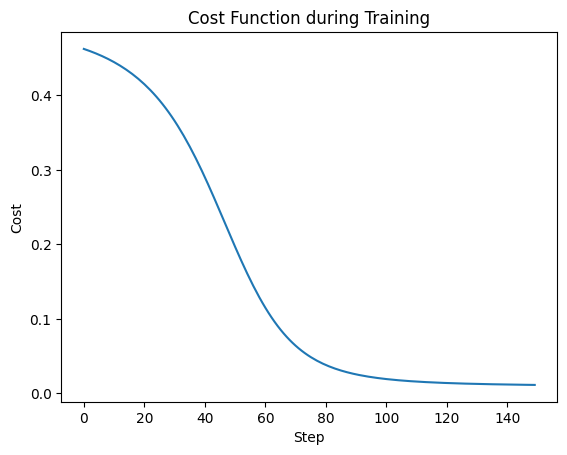

In [18]:
# Traccia la funzione di perdita durante l'addestramento
plt.plot(costs)
plt.xlabel('Step')
plt.ylabel('Cost')
plt.title('Cost Function during Training')
plt.show()